# Assignment 2

## Assumption
1. Polytope is non-degenerate.
2. Rak of A is n

Implement the simplex algorithm to maximize the objective function, You need to implement the method discussed in class.

Input: CSV file with m+2 rows and n+1 column.
             The first row excluding the last element is the initial feasible point z of length n
             The second row excluding the last element is the cost vector c of length n
             The last column excluding the top two elements is the constraint vector b of length m
             Rows third to m+2 and column one to n is the matrix A of size m*n

Output: You need to print the sequence of vertices visited and the value of the objective function at that vertex

## Used Functions


## imports
**Details of Libraries:**
   - **`numpy`** - Importing for the numerical computations, like matrix operations & vector manipulations.
   - **`matplotlib.pyplot`**: Importing for the creation of plots that helps in visualizing results.
   - **`scipy.linalg.null_space`**: Importing for the computing of null space of an matrix, useful in the linear programming & feasibility checks.
   - **`seaborn`**: The visualization library built on top of `matplotlib`, will be used here for enhancing aesthetic quality of the plots.
   - **`csv`**: For reading & writing CSV files containing input data.
   - **`warnings`**: For controlling & manage warnings during program execution

In [4]:
# importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import null_space
import seaborn as sns
import csv
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

## Reading CSV file

This `read_csv` function will read i/p CSV file & extract required components for simplex algorithm. It will open file & convert data from that file into structured NumPy arrays-  first row going for parsing as initial feasible solution, second row as cost vector, and last column of remaining rows as right-hand side vector. Preceeding columns from those rows form constraint matrix. This function makes sure that data is correctly structured & ready for use in solving linear programming problem and also streamlining input process & minimizing manual errors.

In [5]:
def read_csv(filename):
    # to read CSV file (input) and extract init_feasible_sol, cost_vec, A, and rhs_vec matrix
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        data = list(reader)

    # Extracting the initial feasible solution from 1st row
    init_feasible_sol = np.array([float(x) for x in data[0][:-1]])

    # Extracting the cost vector from the second row
    cost_vec = np.array([float(x) for x in data[1][:-1]])

    # Extracti gthe right-hand side (RHS) vector from  remaining rows
    rhs_vec = np.array([float(row[-1]) for row in data[2:]])

    # Extracting constraints matrix
    A = np.array([[float(x) for x in row[:-1]] for row in data[2:]])

    return A, init_feasible_sol, rhs_vec, cost_vec

## Reading & Visualizing Input Data

This code is reading CSV input file using `read_csv` function for extracting necessary components for simplex algorithm, such as constraint matrix, initial feasible solution, cost vectors & right-hand side vector. It will print the matrices to console for verification. Additionally, the heatmap of constraint matrix is plotted using `seaborn` library for visualzing represented structure of constraints. This will helps us in understanding relationships between variables & constraints in linear programming problem.

Constraint Matrix (A):
 [[ 1.  2.]
 [ 0. -1.]
 [-1. -1.]]

Initial Feasible Solution (init_feasible_sol): [1. 1.]

Cost Vector (cost_vec): [2. 1.]

Right-Hand Side Vector (rhs_vec): [4. 1. 1.]


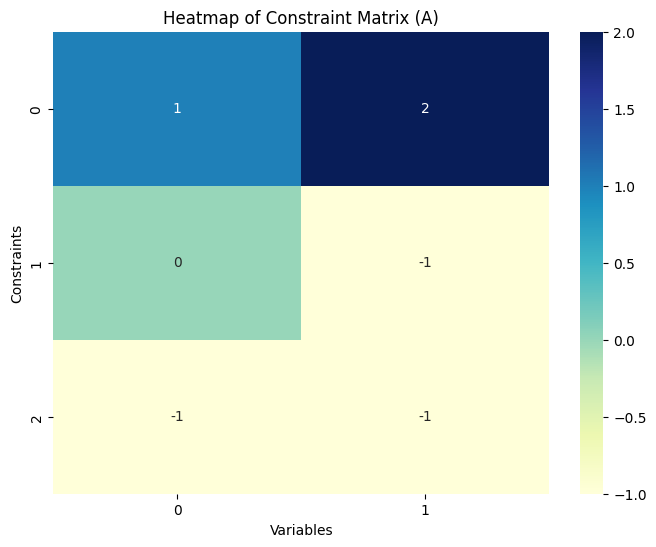

In [6]:
# to read the CSV file (input)
A, init_feasible_sol, rhs_vec, cost_vec = read_csv('testcase_2.csv')

# Printing the matrices
print("Constraint Matrix (A):\n", A)
print("\nInitial Feasible Solution (init_feasible_sol):", init_feasible_sol)
print("\nCost Vector (cost_vec):", cost_vec)
print("\nRight-Hand Side Vector (rhs_vec):", rhs_vec)

# Ploting heatmap of constraint matrix A
plt.figure(figsize=(8, 6))
sns.heatmap(A, annot=True, cmap="YlGnBu", cbar=True)
plt.title('Heatmap of Constraint Matrix (A)')
plt.xlabel('Variables')
plt.ylabel('Constraints')
plt.show()

##  Identifying Tight Rows in Constraint Matrix

`find_tight_rows` function identifies which constraints in matrix $A$ are tight for given initial feasible solution. It perform this by computing the difference between result of dot product of $A$ & initial solution and right-hand side vector $b$. If the absolute difference is smaller than the specified tolerance $epsilon$, then that row is considered tight. Function then separates matrix $A$ into 2 parts - `tight_rows`, which will be containing rows where constraints are tight & `untight_rows`, which contains rows where constraints are not tight. This distinction is very important to determine which constraints are active in that feasible region of solution.

In [7]:
# determining tight rows from constraint matrix
def find_tight_rows(A, init_feasible_sol, rhs_vec, epsilon=1e-8):

    # Checking if the diff is less than a small epsilon to identify tight rows
    tight_mask = np.abs(np.dot(A, init_feasible_sol) - rhs_vec) < epsilon

    # Selecting the rows where the constraint is tight
    tight_rows = A[tight_mask]

    # Selecting the rows where the constraint are not tight
    untight_rows = A[~tight_mask]

    return tight_mask, tight_rows, untight_rows

## Identifying Tight & Untight Constraints for Initial Feasible Solution

This code calls `find_tight_rows` function for determining  which constraints are tight for the given initial feasible solution. Function returns the mask which is indicating tightness of each constraint as well as specific rows in constraint matrix $A$ that are tight (`tight_rows`) & those that are found untight (`untight_rows`). This separation is important for the understanding of which constraints actively define the feasible region of current solution in our simplex algorithm.

In [8]:
# Find tight rows for initial feasible solution
mask, tight_rows, untight_rows = find_tight_rows(A, init_feasible_sol, rhs_vec)

## Transitioning to a Feasible Vertex

`feasible_to_vertex` function is designed for converting initial feasible solution into vertex of feasible region for linear programming problem. It starts by calculating the cost at initial solution & then identifies tight constraints using our `find_tight_rows` function. If no tight constraints are present or rank of tight constraints is less than number of variables, function will determine direction for moving in solution space. This direction is derived either from null space of tight constraints or chosen randomly if no tight constraints exist. Function will then calculate step size (alpha used below) for moving in that direction which will be ensuring updated solution remains feasible. Process then repeats iteratively, updating solution & tracking visited vertices, until vertex is found and all the constraints are satisfied. This function is crucial for generating feasible solutions that will guide simplex algorithm towards optimal solution.

In [9]:
def feasible_to_vertex(A, rhs_vec, init_feasible_sol, cost_vec, n):
    # to convert initial_feasible_point into a vertex

    vertices = []
    costs = []
    iteration = 0
    costs.append(np.dot(cost_vec, init_feasible_sol))
    vertices.append(init_feasible_sol)

    mask, tight_rows, untight_rows = find_tight_rows(A, init_feasible_sol, rhs_vec)

    while len(tight_rows) == 0 or np.linalg.matrix_rank(tight_rows) < n:
        print(f"Iteration {iteration}: Current Cost = {costs[-1]}, Current Vertex = {init_feasible_sol}")

        if len(tight_rows) != 0:
            direction = null_space(tight_rows)[:, 0]  # Direction from null space
        else:
            direction = np.random.rand(untight_rows.shape[-1])  # Random direction

        # Initialize an empty array for alpha values
        while True:
            alphas = []

            # Iterating through the rhs_vec and untight_rows
            for b_i, a_i in zip(rhs_vec[~mask], untight_rows):
                # Compute the denominator, the dot product of a_i and the direction
                denominator = np.dot(a_i, direction)

                # Check if the denominator is positive, indicating a valid direction
                if denominator > 0:
                    # Calculate the numerator as the difference between b_i and the dot product of a_i with init_feasible_sol
                    numerator = b_i - np.dot(a_i, init_feasible_sol)

                    # Compute the alpha value as the ratio of numerator to denominator
                    alpha = numerator / denominator

                    # Append the alpha value to the list
                    alphas.append(alpha)

            # Check if there are no valid alphas (unbounded case)
            if len(alphas) == 0:
                direction = -1 * direction  # Reverse the direction
            else:
                break  # Valid alphas found, exit the loop

        # Finding the minimum value of alphas
        alpha = min(alphas)
        # Updateing the initial feasible solution by moving in the direction specified by direction and step size will determined by alpha
        init_feasible_sol = init_feasible_sol + alpha * direction

        # Appending the updated feasible solution
        vertices.append(init_feasible_sol)

        #cost is computed as the dot product of the cost vector and the updated solution
        costs.append(np.dot(cost_vec, init_feasible_sol))

        mask, tight_rows, untight_rows = find_tight_rows(A, init_feasible_sol, rhs_vec)

        # incrementing the iteration
        iteration += 1

    return init_feasible_sol, costs, vertices

## Converting Initial Feasible Solution to a Vertex and Tracking Costs

This code is defining no. of variables (n) based on number of columns in that constraint matrix $A$. It calls `feasible_to_vertex` function to convert initial feasible solution into the vertex of feasible region. Function returns updated solution (`init_feasible_sol`), sequence of costs at each vertex (`costs`), and list of vertices visited during process (`vertices`). This step is essential for moving from an initial feasible solution to an optimal vertex while tracking objective function values throughout iterations.

In [10]:
# Defining number of variables
n = A.shape[1]

# Convert feasible point to a vertex
init_feasible_sol, costs, vertices = feasible_to_vertex(A, rhs_vec, init_feasible_sol, cost_vec, n)

Iteration 0: Current Cost = 3.0, Current Vertex = [1. 1.]
Iteration 1: Current Cost = 3.6189366341346076, Current Vertex = [1.07929109 1.46035446]


## Plotting Cost Changes During Conversion to the Vertex

This code is plotting changes in objective function values over the iterations as initial feasible solution is converted into the vertex. The `costs` list, containing objective values at each vertex visited, is used for creating line plot with iteration numbers on x-axis & corresponding objective values on y-axis. The plots plotted by this will help in visualizing how objective function evolves as algorithm progresses towards finding an optimal vertex in the feasible region. Grid & markers on plots are enhancing readability and also providing the clear view of changes at each step.

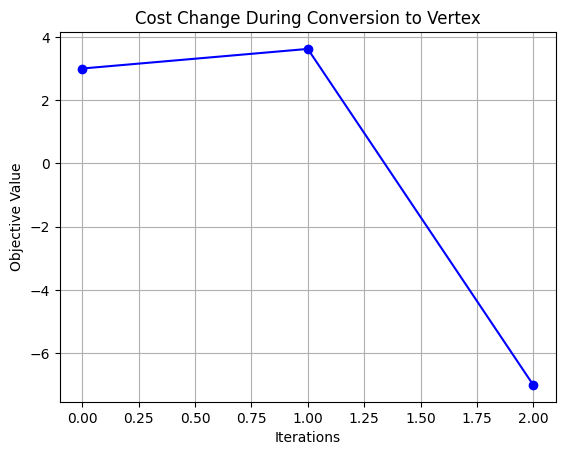

In [11]:
# Plot cost changes during the conversion process
plt.plot(range(len(costs)), costs, marker='o', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Objective Value')
plt.title('Cost Change During Conversion to Vertex')
plt.grid(True)
plt.show()

### Computing Directions Using Tight Constraints

The `compute_directions` function computes direction vectors based on the tight constraints of the current solution. It takes the matrix of tight constraints as input, where each row represents a constraint that is active for the given solution. The function attempts to calculate the inverse of the tight rows matrix and returns its negative value. This inverse matrix is used to determine the direction of movement within the feasible region. If the matrix is singular (non-invertible), an exception is raised and the function prints an error message, returning `None` to indicate that the direction could not be computed. This function is crucial for the simplex algorithm, as it helps identify the direction in which the solution can move to improve the objective function.

In [12]:
# This fuction is for computing vectors using the tight rows.
def compute_directions(tight_rows):
    #  It is taking matrix of tight constraints as input.
    # Each row is representing the constraints that are currently active for given solution

    try:
        return -np.linalg.inv(tight_rows) # This is computing & returning - ve inverse of tight rows matrix.
    except np.linalg.LinAlgError:
        # If an tight_rows matrix is singular (i.e. non invertible) then the exception is raised.
        print("It is Singular Matrix, So cannot compute directions.")   # Handling non invertible matrix
        return None # Returning None for indicating that the directions could not be computed


## Vertex Optimization Using the Simplex Method

The `vertex_optimization` function implements the core of the Simplex method to optimize the solution iteratively by moving from one vertex to the next. The function starts by initializing the lists to store the visited vertices and the corresponding objective function values. It begins with the given initial feasible solution and its associated cost.

In each iteration, the function:
1. Identifies the tight and untight constraints by calling the `find_tight_rows` function.
2. Computes the potential directions for movement based on the tight constraints using the `compute_directions` function.
3. Filters the directions by checking which ones improve the objective function (positive dot product with the cost vector).
4. If no improving direction is found, the algorithm terminates, indicating the optimal solution has been reached.
5. If improving directions exist, it selects the first one and computes step sizes (alphas) for the untight constraints.
6. The smallest positive alpha determines the step size to move towards the next vertex.
7. The solution is updated by moving along the chosen direction, and the new vertex is added to the list of visited vertices.
8. The objective function value at the new solution is computed and stored.

The loop continues until no improving direction is found, indicating that the optimal solution has been reached.

Finally, the function returns the optimal solution, the sequence of costs, and the vertices visited during the optimization process.

This function forms the heart of the Simplex algorithm, iterating through feasible solutions and improving the objective function at each step until an optimal vertex is found.


In [13]:
# This function for optimizing an solution by moving iteratively to the next vertex from one vertex using Simplex Method.
def vertex_optimization(A, rhs_vec, init_feasible_sol, cost_vec):

    vertices = []   # This is  List for Storing the visited vertices
    costs = []      # This is List for storing objective function at each vertex
    iteration = 0

    # Appending initial feasible solution &  its cost to lists.
    vertices.append(init_feasible_sol)
    costs.append(np.dot(cost_vec, init_feasible_sol))

    while True:
        # Current iteration details printing
        print(f"Iteration {iteration}: Current Cost = {costs[-1]}, Current Vertex = {init_feasible_sol}")

        # For current solution, identifing tight & untight constraints
        mask, tight_rows, untight_rows = find_tight_rows(A, init_feasible_sol, rhs_vec)

        # Computign the potential directions for the movement based on tight constraints
        directions = compute_directions(tight_rows).T

        # Checking dot product with cost vector & Filtering directions
        positive_directions = []
        for d in directions:
            if np.dot(d, cost_vec) > 0:
                positive_directions.append(d)

        if not positive_directions:
            break

        # Choosing first improving direction
        direction = positive_directions[0]

        # Compute step sizes - alphas, for untight constraints
        alphas = [(b_i - np.dot(a_i, init_feasible_sol)) / np.dot(a_i, direction)
                  for b_i, a_i in zip(rhs_vec[~mask], untight_rows)]
        positive_alphas = [alpha for alpha in alphas if alpha > 0]

        if len(positive_alphas) == 0:  # Handling unbounded case
            print("\nThe problem is unbounded!")
            return None, costs, vertices


        # Updating  solution for next vertex along direction which is chosen
        init_feasible_sol = init_feasible_sol + min(positive_alphas) * direction

        # Recording new solution & its objective function value of that solution
        costs.append(np.dot(cost_vec, init_feasible_sol))
        vertices.append(init_feasible_sol)

        # Incramenting counter of iterator
        iteration += 1
    # Returning here optimal solution, sequence of costs & visited vertices
    return init_feasible_sol, costs, vertices


## Optimizing the Solution Using the Simplex Method

This code snippet calls the `vertex_optimization` function to perform the optimization process using the Simplex method. The function takes the constraint matrix $A$, the right-hand side vector (`rhs_vec`), the initial feasible solution (`init_feasible_sol`), and the cost vector (`cost_vec`) as inputs. It returns the optimal vertex (`optimal_vertex`), the sequence of costs at each visited vertex (`optimization_costs`), and the list of visited vertices (`optimization_vertices`). The optimization process iterates through feasible solutions, improving the objective function at each step, until the optimal solution is found.


## Checking for Unbounded Solution and Plotting Tight Constraints Over Iterations

In this code block, the solution is first checked for unboundedness. If the `optimal_vertex` is `None` (indicating that no valid solution was found), it prints a message indicating that the problem is unbounded and stops further computation.

If the solution is not unbounded, the code proceeds with further visualization. A plot is generated to show how the number of tight constraints changes over the iterations of the Simplex algorithm. For each visited vertex in the list `vertices`, the `find_tight_rows` function is used to determine how many tight constraints are active at that vertex. This count is then plotted against the iteration number.

The plot helps visualize how the set of active constraints evolves as the algorithm progresses, providing insight into the changing feasible region and the constraints that govern the solution at each step.


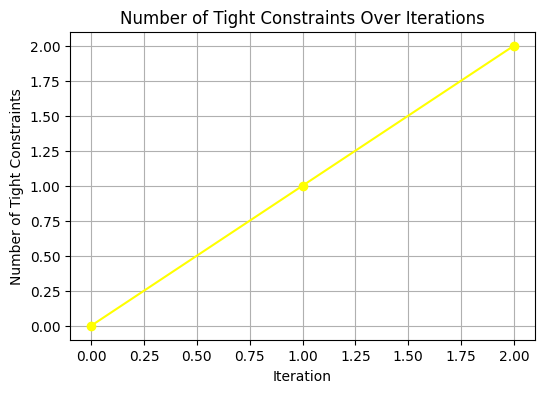

In [14]:
# Check if the solution is unbounded

# Proceed with plotting or further computations
plt.figure(figsize=(6, 4))
plt.plot(range(len(vertices)), [np.sum(find_tight_rows(A, v, rhs_vec)[0]) for v in vertices], marker='o', color='yellow')
plt.xlabel('Iteration')
plt.ylabel('Number of Tight Constraints')
plt.title('Number of Tight Constraints Over Iterations')
plt.grid(True)
plt.show()

In [15]:
# Optimizing the vertex using the Simplex method
print("\nSequence of visited Vertices are as follows:")
optimal_vertex, optimization_costs, optimization_vertices = vertex_optimization(A, rhs_vec, init_feasible_sol, cost_vec)

print("\nOptimal vertex is as follows:")
print(f"Point: {optimization_vertices[-1]}")
print(f"Value of objective function: {optimization_costs[-1]}")



Sequence of visited Vertices are as follows:
Iteration 0: Current Cost = -7.0000000000000036, Current Vertex = [-6.  5.]
Iteration 1: Current Cost = -1.0, Current Vertex = [ 0. -1.]
Iteration 2: Current Cost = 11.0, Current Vertex = [ 6. -1.]

Optimal vertex is as follows:
Point: [ 6. -1.]
Value of objective function: 11.0
